# Description du MDP et exemple d'utilisation 

In [1]:
using POMDPs
using QuickPOMDPs
using Distributions
using Distributions: DiscreteUniform, pdf
using POMDPTools: Deterministic
using POMDPTools
using Statistics
using POMDPs: states, actions, transition, reward
using TabularTDLearning
using Random
using StatsBase: Weights
using Plots
using DataFrames
using POMDPs
using JuMP
using GLPK
using LinearAlgebra
using TabularTDLearning         # Q‑Learning & SARSA solvers
using POMDPTools: EpsGreedyPolicy, DiscreteBelief

In [2]:
using POMDPs
using QuickPOMDPs
using Distributions
using Random
using POMDPTools: Deterministic

const MAX_INVENTORY = 20
const MAX_STORE = 10
const ORDER_SIZE = 5

const holding_cost_store = 2
const holding_cost_parking = 4
const order_cost = 20
const stockout_penalty = 50

const demand_dist = DiscreteUniform(0, 10)

mdp = QuickMDP(
    
    states = 0:MAX_INVENTORY,
    actions = [0, 1],
    discount = 0.99,

    gen = function (s, a, rng)
        order_qty = a == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s) : 0
        new_stock = s + order_qty

        d = rand(rng, demand_dist)
        sold = min(d, new_stock)
        sp = new_stock - sold

        lost_sales = max(d - new_stock, 0)

        in_store = min(sp, MAX_STORE)
        in_parking = max(sp - MAX_STORE, 0)

        cost = 0
        cost += a == 1 ? order_cost : 0
        cost += in_store * holding_cost_store
        cost += in_parking * holding_cost_parking
        cost += lost_sales * stockout_penalty

        r = -cost

        return (sp, r, d)
    end,
    initialstate = Deterministic(10)
)


QuickMDP{Base.UUID("d55a087e-7f66-4f36-8d24-2f94f5f34a3a"), Int64, Int64, @NamedTuple{stateindex::Dict{Int64, Int64}, isterminal::Bool, actionindex::Dict{Int64, Int64}, initialstate::Deterministic{Int64}, states::UnitRange{Int64}, actions::Vector{Int64}, discount::Float64, gen::var"#11#12"}}((stateindex = Dict(5 => 6, 16 => 17, 7 => 8, 20 => 21, 12 => 13, 8 => 9, 17 => 18, 1 => 2, 19 => 20, 0 => 1…), isterminal = false, actionindex = Dict(0 => 1, 1 => 2), initialstate = Deterministic{Int64}(10), states = 0:20, actions = [0, 1], discount = 0.99, gen = var"#11#12"()))

In [3]:
rng = MersenneTwister(42)
s = 8
a = 1
for i in 1:10
    sp, r, d = POMDPs.gen(mdp, s, a, rng)
    println("From $s --(a=$a)--> $sp,  Demand: $d, Reward = $r")
end


From 8 --(a=1)--> 11,  Demand: 2, Reward = -44
From 8 --(a=1)--> 4,  Demand: 9, Reward = -28
From 8 --(a=1)--> 9,  Demand: 4, Reward = -38
From 8 --(a=1)--> 6,  Demand: 7, Reward = -32
From 8 --(a=1)--> 6,  Demand: 7, Reward = -32
From 8 --(a=1)--> 6,  Demand: 7, Reward = -32
From 8 --(a=1)--> 3,  Demand: 10, Reward = -26
From 8 --(a=1)--> 5,  Demand: 8, Reward = -30
From 8 --(a=1)--> 11,  Demand: 2, Reward = -44
From 8 --(a=1)--> 12,  Demand: 1, Reward = -48


In [4]:
n_states = 21 # 0 -> 20
n_actions = 2 # 0 ou 1
# Q = zeros(Float64, n_states, n_actions)


function my_Q_learing(mdp, α, ϵ, Q0; n_states = 21, n_actions = 2, epochs = 100, iterations = 10_000, s0 = 10, γ = 0.99)
    rng = MersenneTwister(12344)

    # Q = zeros(Float64, n_states, n_actions) # Defining the Q(s, a) function
    Q_temp =  zeros(Float64, n_states, n_actions)
    Q_temp .= Q # Defining the Q(s, a) function

    ERR = []


    for i in 1:iterations
        s = s0

        for t in 1:epochs
            a = rand() < ϵ ? rand([1, 0]) : argmax(Q[s + 1, : ]) - 1    
            
            sp, r, _ =  POMDPs.gen(mdp, s, a, rng)
            Q_temp[s+1, a+1] += α * (r + γ * maximum(Q[sp+1, :]) - Q_temp[s+1, a+1])
            s = sp

        end

        
        if i % 10 == 0
            err = norm(Q - Q_temp)
            # println(err)
            push!(ERR, err)
            Q .= Q_temp
        end
    end
    
    return Q_temp, ERR
end


my_Q_learing (generic function with 1 method)

In [5]:
s = 10
α = 0.1
ϵ = 0.1
Q = zeros(Float64, n_states, n_actions)
Q, ERR = my_Q_learing(mdp, α, ϵ, Q, epochs = 30, iterations = 1000)

([-2329.8340183729515 -2143.4934453805263; -2233.2230213011794 -2130.6046103714866; … ; -1540.8643737445595 -1582.4293101787337; -1495.2862892021624 -1506.0077649441796], Any[283.45003710109296, 172.09629001977441, 316.83279316120985, 214.07440245368383, 286.8081666309624, 251.2911362336058, 247.49302735441626, 290.3801683945694, 196.18693390993067, 194.331503676312  …  262.7223749206167, 165.29296035466183, 163.7520332739029, 144.90912453259415, 155.77635037924057, 232.19207118715752, 213.496833867297, 200.1981156037471, 169.72772312259022, 157.09890817244565])

In [6]:
s = 10
α = 0.1
ϵ = 0.01
Q, ERR2 = my_Q_learing(mdp, α, ϵ, Q, epochs = 30, iterations = 10000)

([-5051.722084628214 -4839.991129089974; -5020.9613974184995 -4811.938034814046; … ; -4664.520409985499 -4665.965495511201; -4636.959541740647 -4641.4576222466585], Any[209.78503719000454, 256.4327779333679, 214.67809151641524, 167.912475187302, 196.1370079657365, 163.7991548013662, 375.210574302587, 259.0122006340633, 171.9989179991952, 190.15912228356882  …  60.50036890206835, 38.67747703342426, 43.8627311896594, 47.281391345273846, 73.91669861481518, 80.45897465374229, 90.1961455061758, 49.71719432890761, 52.871128343024814, 96.53849566521892])

In [7]:
for e in ERR2
    push!(ERR, e)
end

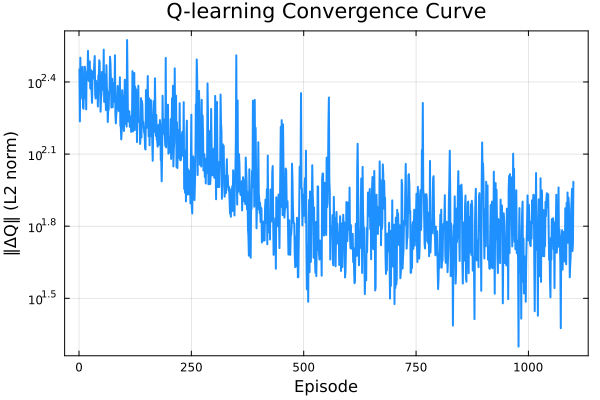

In [8]:
using Plots
using POMDPs
using QuickPOMDPs
using Distributions
using Distributions: DiscreteUniform, pdf
using POMDPTools: Deterministic
using POMDPTools
using Statistics
using POMDPs: states, actions, transition, reward
using TabularTDLearning
using Random
using StatsBase: Weights
using Plots
using DataFrames
using POMDPs
using JuMP
using GLPK
plot(ERR;
    xlabel = "Episode",
    ylabel = "‖ΔQ‖ (L2 norm)",
    yscale = :log10,
    lw = 2,
    color = :dodgerblue,
    legend = false,
    title = "Q-learning Convergence Curve",
    grid = :on,
    framestyle = :box
)


## Benchmarking the Q_learning

In [9]:
function benchmark_policy(policy, mdp; episodes=1_000_000, horizon=30, rng=MersenneTwister(42))
    total_rewards = zeros(episodes)

    for ep in 1:episodes
        s = 10  # start state
        ep_reward = 0.0

        for t in 1:horizon
            a = policy[s + 1]  # select action from learned policy
            sp, r, _ = POMDPs.gen(mdp, s, a, rng)  # simulate next step
            ep_reward += r
            s = sp
        end

        total_rewards[ep] = ep_reward
    end

    mean_reward = mean(total_rewards)
    std_reward = std(total_rewards)

    return mean_reward, std_reward, total_rewards
end


benchmark_policy (generic function with 1 method)

Benchmark results for learned Q-learning policy:
  Mean total reward over episodes: -1399.121552
  Std. deviation: 359.81211735275275


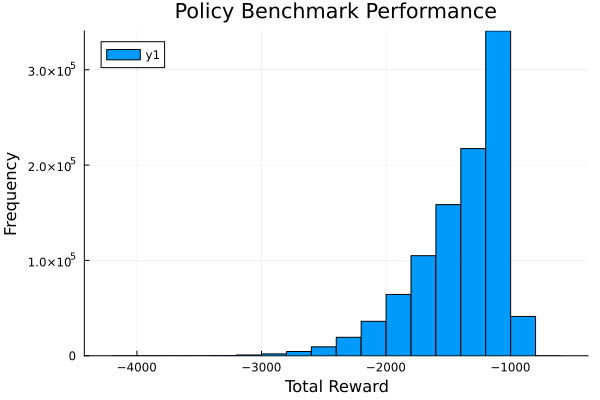

In [10]:
policy = [argmax(Q[s+1, :]) - 1 for s in 0:MAX_INVENTORY]
mean_r, std_r, rewards = benchmark_policy(policy, mdp)

println("Benchmark results for learned Q-learning policy:")
println("  Mean total reward over episodes: $mean_r")
println("  Std. deviation: $std_r")

using Plots
histogram(rewards, bins=30, xlabel="Total Reward", ylabel="Frequency", title="Policy Benchmark Performance")


In [21]:
N_eval = 1_000_0
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))

println("Starting benchmark for the Q_learning for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
      println("α = $α | ϵ = $ϵ")
      Q = zeros(Float64, n_states, n_actions)
      Q, _ = my_Q_learing(mdp, α, ϵ, Q, epochs = 30, iterations = 1_000_0)
      π = [argmax(Q[s+1, :]) - 1 for s in states(mdp)]

      total_rewards = zeros(N_eval)

      for k in 1:N_eval
         s = 10
         total_r = 0.0

         for t in 1:30
            a = π[s+1]
            s, r  = POMDPs.gen(mdp, s, a, rng)
            # s, r = out.sp, out.r
            # total_r += r * discount(mdp)^(t - 1)
            # total_r += r 
            total_r = r +  total_r * 0.99
         end
         total_rewards[k] = total_r
      end

      mean_r = mean(total_rewards)
      std_r = std(total_rewards)
      # mean_r, std_r, rewards = benchmark_policy(π, mdp)
      returns_mean[i, j] = mean_r
      returns_std[i, j] = std_r
        
   end
end


Starting benchmark for the Q_learning for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
α = 0.2 | ϵ = 0.1
α = 0.2 | ϵ = 0.01
α = 0.2 | ϵ = 1.0e-5
α = 0.1 | ϵ = 0.2
α = 0.1 | ϵ = 0.1
α = 0.1 | ϵ = 0.01
α = 0.1 | ϵ = 1.0e-5
α = 0.01 | ϵ = 0.2
α = 0.01 | ϵ = 0.1
α = 0.01 | ϵ = 0.01
α = 0.01 | ϵ = 1.0e-5
α = 1.0e-5 | ϵ = 0.2
α = 1.0e-5 | ϵ = 0.1
α = 1.0e-5 | ϵ = 0.01
α = 1.0e-5 | ϵ = 1.0e-5


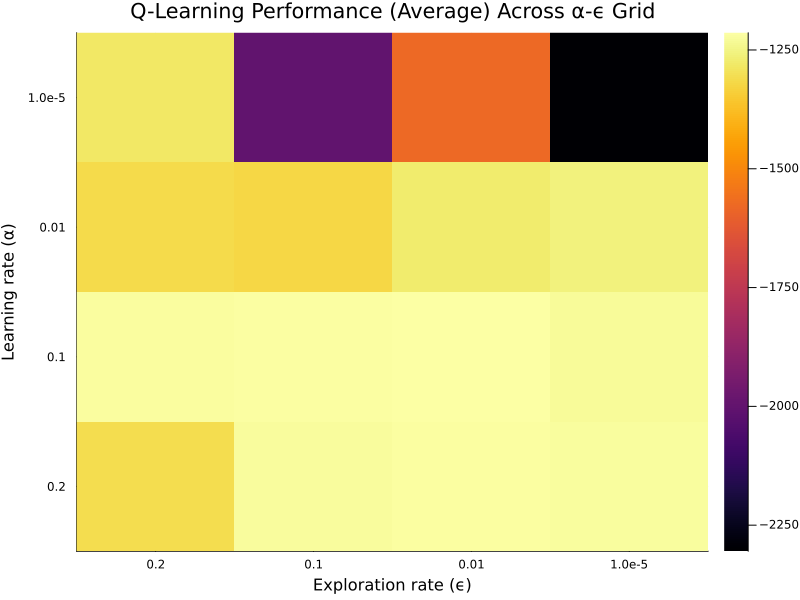

In [22]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

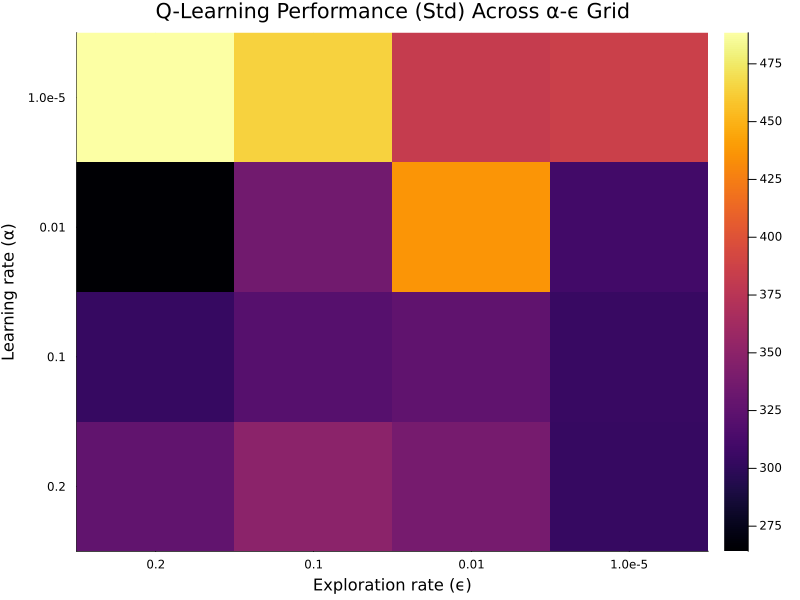

In [13]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_std;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Std) Across α-ϵ Grid",
    # c = :viridis,
)

# Question 3

In [14]:
mdp_q3 = QuickMDP(
    states     = 0:MAX_INVENTORY,
    actions    = [0, 1],            
    discount   = 0.99,

    gen = function (s, a, rng)
        order_qty = a == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s) : 0
        new_stock = s + order_qty
    
        d = rand(rng, demand_dist)
        sold = min(d, new_stock)
        sp = new_stock - sold
    
        lost_sales = max(d - new_stock, 0)
    
        in_store = min(sp, MAX_STORE)
        in_parking = max(sp - MAX_STORE, 0)
    
        cost = 0
        cost += a == 1 ? order_cost : 0
        cost += in_store * holding_cost_store
        cost += in_parking * holding_cost_parking
        cost += lost_sales * stockout_penalty
    
        r = -cost
    
        return (sp=sp, r=r) 
    end,
    
    initialstate = Deterministic(10)              
)


QuickMDP{Base.UUID("d83ecc0c-2cbb-4899-8a96-9aa9346ce6a4"), Int64, Int64, @NamedTuple{stateindex::Dict{Int64, Int64}, isterminal::Bool, actionindex::Dict{Int64, Int64}, initialstate::Deterministic{Int64}, states::UnitRange{Int64}, actions::Vector{Int64}, discount::Float64, gen::var"#19#20"}}((stateindex = Dict(5 => 6, 16 => 17, 7 => 8, 20 => 21, 12 => 13, 8 => 9, 17 => 18, 1 => 2, 19 => 20, 0 => 1…), isterminal = false, actionindex = Dict(0 => 1, 1 => 2), initialstate = Deterministic{Int64}(10), states = 0:20, actions = [0, 1], discount = 0.99, gen = var"#19#20"()))

## Benchmarking QLearningSolver

In [15]:
N_eval = 1_000_0
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))


function policy_vector(pol)
   [action(pol, s) for s in states(mdp_q3)]
end

println("Starting benchmark for the QLearningSolver for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
      println("α = $α | ϵ = $ϵ")
      
      ql_solver   = QLearningSolver(
                 exploration_policy = EpsGreedyPolicy(mdp_q3, ϵ),
                 learning_rate      = α,
                 n_episodes         = 1_000_0,
                 max_episode_length = 30,
                 eval_every         = 100,
                 n_eval_traj        = 100)


      ql_policy = solve(ql_solver,   mdp_q3) 

      π_ql = policy_vector(ql_policy)


      total_rewards = zeros(N_eval)

      for k in 1:N_eval
         s = 10
         total_r = 0.0

         rng =  MersenneTwister()
         for t in 1:30
            a = π_ql[s+1]
            s, r  = POMDPs.gen(mdp, s, a, rng)
            # s, r = out.sp, out.r
            total_r += r * discount(mdp)^(t - 1)
            # total_r += r 
            # total_r = r +  total_r * 0.99
         end
         total_rewards[k] = total_r
      end

      mean_r = mean(total_rewards)
      std_r = std(total_rewards)
      # mean_r, std_r, rewards = benchmark_policy(π, mdp)
      returns_mean[i, j] = mean_r
      returns_std[i, j] = std_r
        
   end
end


Starting benchmark for the QLearningSolver for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
On Iteration 100, Returns: -1345.9168415936617
On Iteration 200, Returns: -1292.5271710068378
On Iteration 300, Returns: -1362.2107630507192
On Iteration 400, Returns: -1275.6880210292586
On Iteration 500, Returns: -3683.8797235961315
On Iteration 600, Returns: -1340.02157976839
On Iteration 700, Returns: -1229.0325601965421
On Iteration 800, Returns: -1264.6586163142151
On Iteration 900, Returns: -1254.7517212080775
On Iteration 1000, Returns: -1404.798539837428
On Iteration 1100, Returns: -1297.690881685287
On Iteration 1200, Returns: -1235.1166751179462
On Iteration 1300, Returns: -1251.3255045864214
On Iteration 1400, Returns: -1229.371239774207
On Iteration 1500, Returns: -1206.5037326942
On Iteration 1600, Returns: -1197.7391300550562
On Iteration 1700, Returns: -1255.8087953357654
On Iteration 1800, Returns: -1252.2000056488482
On Iteration 190

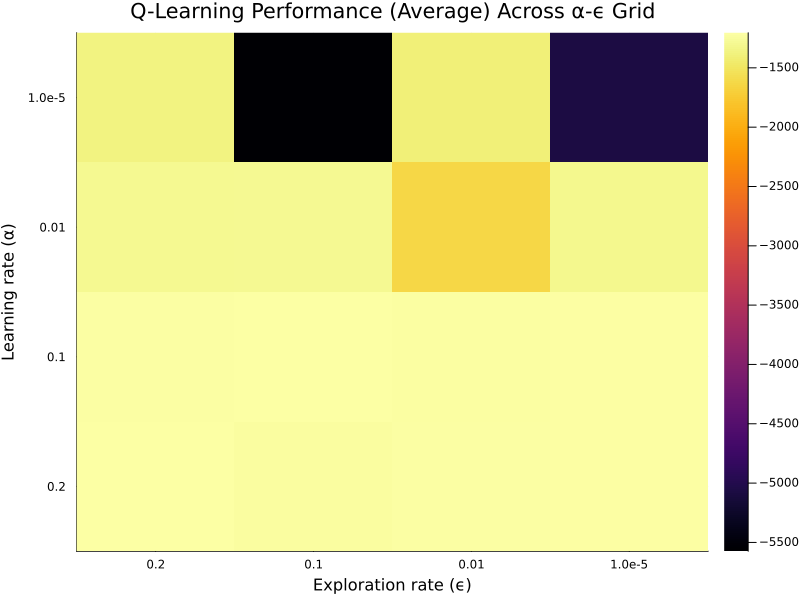

In [16]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

In [17]:
returns_mean

4×4 Matrix{Float64}:
 -1204.51  -1224.39  -1212.2   -1210.13
 -1210.68  -1204.64  -1215.58  -1209.85
 -1294.23  -1287.7   -1631.76  -1306.8
 -1359.38  -5574.04  -1396.9   -5074.69

## Benchmarking SARSASolver

In [18]:
N_eval = 1_000_0
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))


function policy_vector(pol)
   [action(pol, s) for s in states(mdp_q3)]
end

println("Starting benchmark for the QLearningSolver for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
      println("α = $α | ϵ = $ϵ")
      
      ql_solver   = SARSASolver(
                 exploration_policy = EpsGreedyPolicy(mdp_q3, ϵ),
                 learning_rate      = α,
                 n_episodes         = 1_000_0,
                 max_episode_length = 30,
                 eval_every         = 100,
                 n_eval_traj        = 100)


      ql_policy = solve(ql_solver,   mdp_q3) 

      π_ql = policy_vector(ql_policy)


      total_rewards = zeros(N_eval)

      for k in 1:N_eval
         s = 10
         total_r = 0.0

         rng =  MersenneTwister()
         for t in 1:30
            a = π_ql[s+1]
            s, r  = POMDPs.gen(mdp, s, a, rng)
            # s, r = out.sp, out.r
            total_r += r * discount(mdp)^(t - 1)
            # total_r += r 
            # total_r = r +  total_r * 0.99
         end
         total_rewards[k] = total_r
      end

      mean_r = mean(total_rewards)
      std_r = std(total_rewards)
      # mean_r, std_r, rewards = benchmark_policy(π, mdp)
      returns_mean[i, j] = mean_r
      returns_std[i, j] = std_r
        
   end
end


Starting benchmark for the QLearningSolver for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
On Iteration 100, Returns: -1381.4364533672024
On Iteration 200, Returns: -1494.931934117319
On Iteration 300, Returns: -1251.247578366038
On Iteration 400, Returns: -1309.7768111554676
On Iteration 500, Returns: -1239.3517305609366
On Iteration 600, Returns: -1429.7367371667403
On Iteration 700, Returns: -1236.4764621024383
On Iteration 800, Returns: -1554.011774332224
On Iteration 900, Returns: -1252.5322401134174
On Iteration 1000, Returns: -1286.0617768497862
On Iteration 1100, Returns: -1225.652264195645
On Iteration 1200, Returns: -1310.92524431767
On Iteration 1300, Returns: -1187.9801202528588
On Iteration 1400, Returns: -1302.8068982309424
On Iteration 1500, Returns: -1300.6388921219504
On Iteration 1600, Returns: -1267.0002123913137
On Iteration 1700, Returns: -1238.8466407706765
On Iteration 1800, Returns: -1418.2988448674923
On Iteration 1

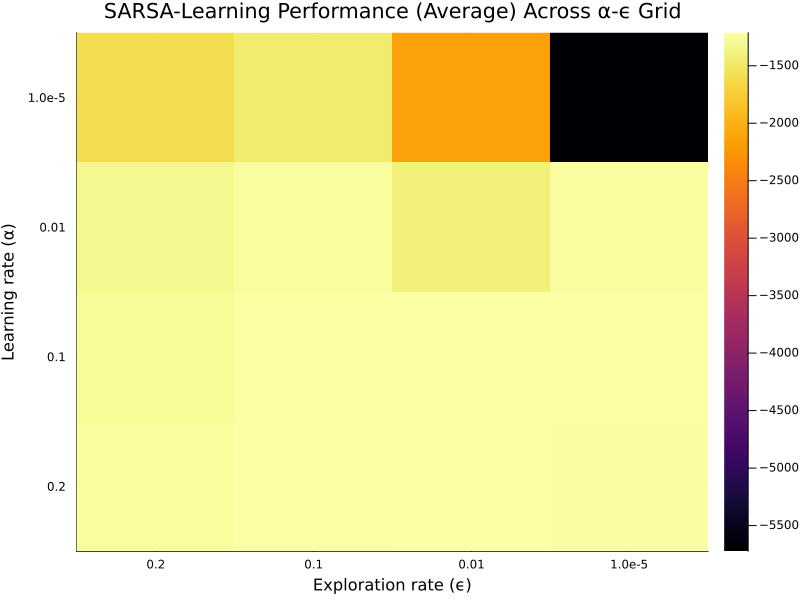

In [19]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "SARSA-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

In [20]:
returns_mean

4×4 Matrix{Float64}:
 -1245.57  -1214.67  -1214.08  -1232.42
 -1271.68  -1217.59  -1213.04  -1214.24
 -1319.18  -1244.41  -1403.26  -1238.35
 -1597.3   -1460.9   -2144.67  -5723.42